In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot
import tensorflow as tf
import pickle
import os

In [2]:
import dataset_utils
from glob import glob

In [3]:
def parse_dataset(num_points, data_dir, num_frames):
    train_points, test_points, train_labels, test_labels = [], [], [], []
    class_map = {}
    folders = glob(os.path.join(data_dir, "[!README]*"))

    for i, folder in enumerate(folders):
        print("Processing class: {}".format(os.path.basename(folder)))
        class_map[i] = folder.split("/")[-1]
        
        train_files = glob(os.path.join(folder, "train/*"))
        test_files = glob(os.path.join(folder, "test/*"))

        # Helper function to group frames into sequences
        def group_frames(frames, num_frames):
            sequences = []
            labels = []
            for start in range(0, len(frames) - num_frames + 1, num_frames):
                sequence = frames[start:start + num_frames]
                if sequence.shape[0] == num_frames:
                    sequences.append(sequence)
                    labels.append(i)
            return sequences, labels

        # Process training data
        all_train_points = []
        for f in train_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    all_train_points.append(arr)
        print(f"Number of arrays loaded: {len(all_train_points)}")  # Debug statement        
        concatenated_train_points = np.concatenate(all_train_points, axis=0)
        num_samples = len(concatenated_train_points) // num_points * num_points
        sampled_data = concatenated_train_points[:num_samples].reshape(-1, num_points, 5)
        
        # Group sampled data into sequences
        sequences, labels = group_frames(sampled_data, num_frames)
        train_points.extend(sequences)
        train_labels.extend(labels)

        # Process testing data
        all_test_points = []
        for f in test_files:
            with open(f, 'rb') as file:
                data = pickle.load(file)
                for arr in data:
                    all_test_points.append(arr)
                
        concatenated_test_points = np.concatenate(all_test_points, axis=0)
        num_samples = len(concatenated_test_points) // num_points * num_points
        sampled_data = concatenated_test_points[:num_samples].reshape(-1, num_points, 5)
        
        # Group sampled data into sequences
        sequences, labels = group_frames(sampled_data, num_frames)
        test_points.extend(sequences)
        test_labels.extend(labels)

    return (
        np.array(train_points),
        np.array(test_points),
        np.array(train_labels),
        np.array(test_labels),
        class_map,
    )



In [4]:
DATA_DIR = "data/entire_field_raw_3_class"
NUM_POINTS = 100
NUM_FRAMES = 3
NUM_CLASSES = 3
BATCH_SIZE = 32
train_points, test_points, train_labels, test_labels, CLASS_MAP = dataset_utils.parse_dataset(NUM_POINTS, DATA_DIR)

# Verify the shapes
print(f"train_points shape: {train_points.shape}")
print(f"test_points shape: {test_points.shape}")
print(f"train_labels shape: {np.array(train_labels).shape}")
print(f"test_labels shape: {np.array(test_labels).shape}")

processing class: walking
processing class: jumping
train_points shape: (652, 100, 5)
test_points shape: (164, 100, 5)
train_labels shape: (652,)
test_labels shape: (164,)


In [5]:
from tensorflow import data as tf_data
import keras
import PointNET

keras.utils.set_random_seed(seed=42)

In [6]:
train_size = 0.8
dataset = tf_data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset = tf_data.Dataset.from_tensor_slices((test_points, test_labels))
train_dataset_size = int(len(dataset) * train_size)

dataset = dataset.shuffle(len(train_points)).map(PointNET.augment)
test_dataset = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

train_dataset = dataset.take(train_dataset_size).batch(BATCH_SIZE)
validation_dataset = dataset.skip(train_dataset_size).batch(BATCH_SIZE)

In [7]:
import keras
import tensorflow as tf
from keras import ops
from keras import layers
from PointNET import tnet, conv_bn, dense_bn
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Layer

In [17]:
import tensorflow as tf
from tensorflow import data as tf_data
import keras
from keras import layers
import numpy as np

keras.utils.set_random_seed(seed=42)

def create_pointnet_model(input_shape, num_points, num_features):
    inputs = keras.Input(shape=input_shape)

    # PointNet feature extraction
    x = tnet(inputs, num_features)
    
    # Convolutional layers
    x = conv_bn(x, 64)
    x = conv_bn(x, 64)
    x = conv_bn(x, 128)
    x = conv_bn(x, 1024)
    
    # GlobalMaxPooling1D
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Reshape((-1, 1024))(x)
    
    # Bidirectional LSTM layers
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True))(x)
    x = layers.Flatten()(x)
    # Fully connected layer
    x = layers.Dense(256, activation='relu')(x)
    
    # Final dense layer
    outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name="pointnet_lstm")
    return model

# Usage
input_shape = (NUM_POINTS, 5)  # Adjust this based on your input data
num_points = 20  # Number of points sampled per node and frame
num_features = 5  # Features per point (R, v, x, y, SNR, in, if)

model = create_pointnet_model(input_shape, num_points, num_features)
model.summary()


Model: "pointnet_lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 100, 5)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 100, 32)   │        192 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 32)   │        128 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_45       │ (None, 100, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 100, 64)   │      2,112 │ activation_45[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 64)   │        256 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_46       │ (None, 100, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 100, 512)  │     33,280 │ activation_46[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 512)  │      2,048 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 100, 512)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ activation_47[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │    131,328 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_48       │ (None, 256)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 128)       │     32,896 │ activation_48[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 128)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 25)        │      3,225 │ activation_49[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 5, 5)      │          0 │ dense_19[0][0]  

 Total params: 3,112,668 (11.87 MB)

 Trainable params: 3,108,124 (11.86 MB)

 Non-trainable params: 4,544 (17.75 KB)

In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint
import os


In [19]:
INIT_TIMESTAMP = "5/09/2024"
checkpoint_dir = os.path.join('model/checkpoints/', INIT_TIMESTAMP)
os.makedirs(checkpoint_dir, exist_ok=True)

In [20]:
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'iter-{epoch:02d}.weights.h5'),  # Save weights after each epoch
    save_weights_only=True,  # Save only weights, not the entire model
    verbose=1  # Print a message when saving
)

In [21]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=[checkpoint_callback]  # Add the checkpoint callback here
)

Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 6.8714 - sparse_categorical_accuracy: 0.5466
Epoch 1: saving model to model/checkpoints/5/09/2024/iter-01.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 6.8000 - sparse_categorical_accuracy: 0.5547 - val_loss: 4.6865 - val_sparse_categorical_accuracy: 0.7405
Epoch 2/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 4.3433 - sparse_categorical_accuracy: 0.9221
Epoch 2: saving model to model/checkpoints/5/09/2024/iter-02.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 4.3340 - sparse_categorical_accuracy: 0.9237 - val_loss: 4.3527 - val_sparse_categorical_accuracy: 0.9771
Epoch 3/20
16/17 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 4.2048 - sparse_categorical_accuracy: 0.9762
Epoch 3: saving model to model/checkpoints/5/09/2024/iter-03.weights.h5
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 4.1978 - sparse_categorical_accuracy: 0.9759 - val_loss: 5.4594 - val_sparse_categorical_accuracy: 0.9924
Epoch 4/20

In [22]:
from matplotlib import pyplot as plt

2024-09-05 22:58:15.619834: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
[[[ 7.046e-01  3.676e+00  1.202e+00  0.000e+00  1.300e+02]
  [ 1.992e+00  3.879e+00  2.014e+00  0.000e+00  1.320e+02]
  [ 7.100e-01  4.543e+00  1.303e+00  0.000e+00  1.620e+02]
  ...
  [ 4.736e-02  3.646e+00  7.686e-01 -3.757e-01  1.660e+02]
  [ 2.174e+00  2.740e+00  1.043e+00  0.000e+00  1.750e+02]
  [ 7.100e-01  4.543e+00  1.303e+00  0.000e+00  1.600e+02]]

 [[ 2.174e+00  2.742e+00  1.041e+00  0.000e+00  1.800e+02]
  [-1.261e+00  4.070e+00  1.352e+00  7.515e-01  2.340e+02]
  [ 2.174e+00  2.742e+00  1.041e+00  0.000e+00  1.820e+02]
  ...
  [ 1.992e+00  3.877e+00  2.018e+00  0.000e+00  1.290e+02]
  [ 2.174e+00  2.742e+00  1.041e+00  0.000e+00  1.780e+02]
  [ 1.992e+00  3.879e+00  2.012e+00  0.000e+00  1.310e+02]]

 [[ 7.100e-01  4.551e+00  1.301e+00  0.000e+00  1.670e+02]
  [ 4.727e-01  3.473e+00  1.146e+00  2.505e-01  3.180e+02]
  [-6.074e-01  3.734e+00  1.598e+00  5.010e-01  2.850e+02]
  ...
  [ 7.046e-01  3.686e+00  1.191e+00  0.000e+00  1.350e

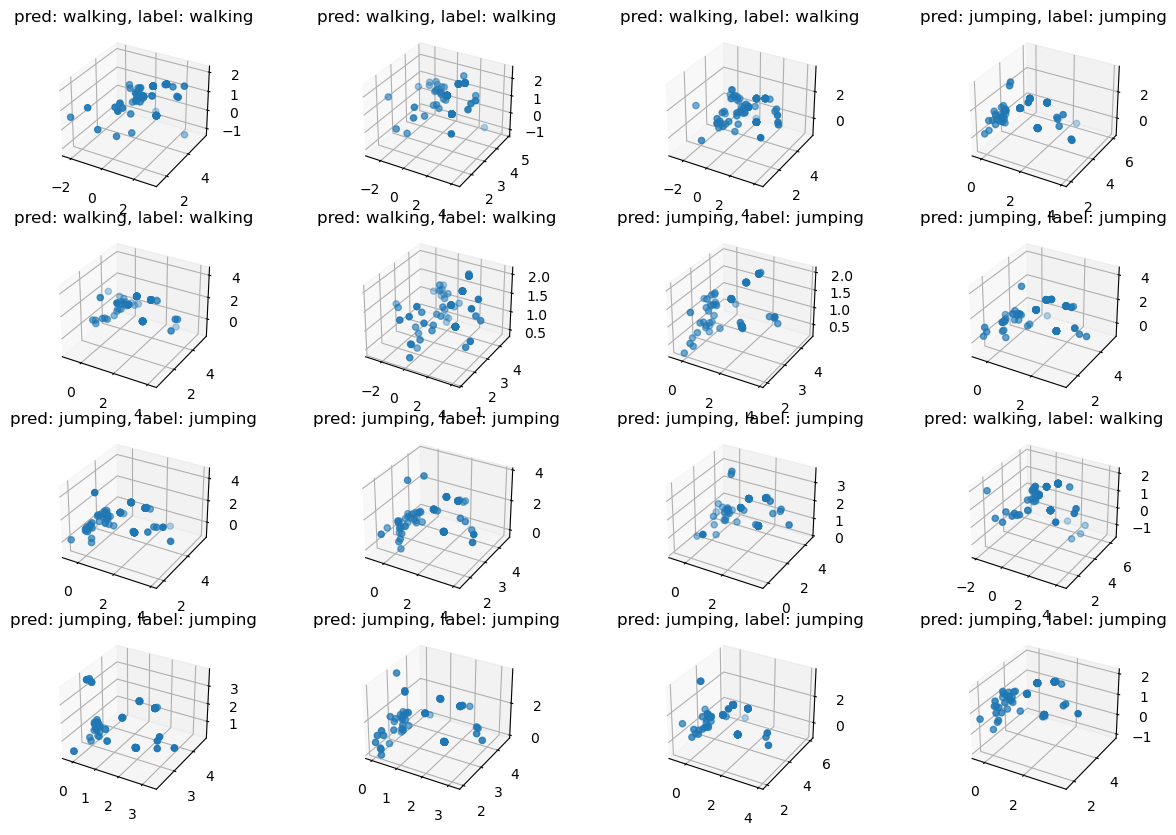

In [23]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:20, ...]
labels = labels[:20, ...]

# run test data through model
preds = model.predict(points)
preds = ops.argmax(preds, -1)

points = points.numpy()
print(points)

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_on()
plt.show()

In [24]:
predictions = []

# Calculate the number of sections, ensure it's at least 1
num_sections = max(1, len(test_points) // NUM_POINTS)

for batch in np.array_split(test_points, num_sections): 
    preds = model.predict(batch)
    preds = np.argmax(preds, axis=-1)
    predictions.extend(preds)

predictions = np.array(predictions)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [25]:
accuracy = np.sum(predictions == test_labels) / len(test_labels)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.34%


In [26]:
print(test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


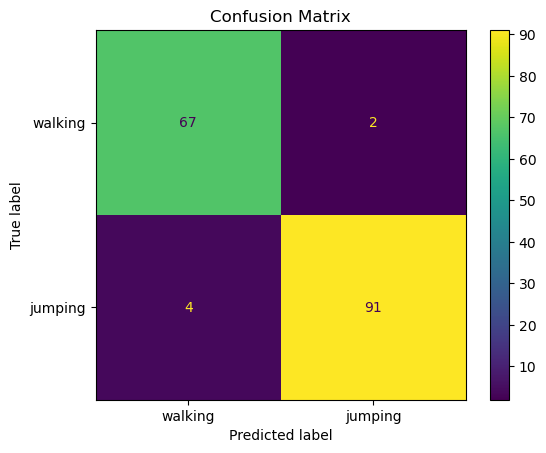

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Plotting the confusion matrix
# Compute the confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plotting the confusion matrix
class_names = ['walking', 'jumping']  # Based on your CLASS_MAP
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)

# Display the plot
disp.plot()
plt.title("Confusion Matrix")
plt.show()


In [31]:
#reload model
reload_model = create_pointnet_model(input_shape, num_points, num_features)
reload_model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

In [33]:
reload_model.load_weights('model/checkpoints/5_09_2024_pointnet_lstm/iter-20.weights.h5')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'model/checkpoints/5_09_2024/iter-20.weights.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)